# Project Requirements

<pre>
    * Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, 
      and checking for correlations and other relations between variables and other EDA elements.
    
    * Perform statistical inference. This should include defining the target population, forming multiple statistical hypotheses and 
      constructing confidence intervals, setting the significance levels, and conducting z or t-tests for these hypotheses.
    
    * Apply various machine learning models to predict the "stroke" column using all other features. This should include 
      hyperparameter tuning, model ensembling, the analysis of model selection, and other methods. 
        Suggestion: you might want to investigate how to use scikit-learn pipelines to make your training pipelines more robust.
    
    * Deploy the machine learning model. Choose the best performing model and deploy it. You are free to choose any deployment
      option that you like - you can deploy your model in a container (on your computer or on a server), do a serverless deployment
      on the cloud, or even deploy and serve it on the browser as a web app.
    
    * Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, 
      what results did you get, and what these results mean.
    
    * Provide suggestions about how your analysis can be improved.

</pre>

In [1]:
import pandas as pd
from sklearn.compose import make_column_selector as selector
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## 1.1 Data Cleaning

In [5]:
# drop unused "id" column which unique for each record

df.drop(['id'], axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
int(df.duplicated().sum())

0

## 1.2 Understand Data & Missingness

In [7]:
# mising data check

missing_counts = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

missing_df = missing_df[missing_df['Missing Count'] > 0]
missing_df

,Missing Count,Missing %
bmi,201,3.933464


# Class imbalance diagnostic

In [8]:
class_per = df['stroke'].value_counts()/len(df['stroke'])*100
class_per

stroke
0    95.127202
1     4.872798
Name: count, dtype: float64

In [9]:
missing_rows = df[df['bmi'].isnull()==True]
class_per_after = (missing_rows['stroke'].value_counts()/df['stroke'].value_counts())*100
class_per_after

stroke
0     3.312076
1    16.064257
Name: count, dtype: float64

In [10]:
filled_rows = df[df['bmi'].isnull()==False]
filled_rows['stroke'].value_counts()/len(filled_rows['stroke'])*100

stroke
0    95.742514
1     4.257486
Name: count, dtype: float64

#### Missing BMI and Stroke Class Observations

- Stroke = 1 is a minority class (~4.9% of data).
- 40 out of 249 stroke=1 rows (~16%) have missing BMI.
- Dropping these would remove many positive cases, hurting model performance.

#### Considerations

- Impute missing BMI (e.g., median) to keep all samples.
- Add a missing indicator column (`bmi_missing`) to flag missing BMI.
- Apply balancing methods later to address class imbalance.

This approach helps preserve data and reduce bias from missing values.


In [11]:
missing_data = missing_rows.drop('bmi', axis=1)

In [12]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201 entries, 1 to 5105
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             201 non-null    object 
 1   age                201 non-null    float64
 2   hypertension       201 non-null    int64  
 3   heart_disease      201 non-null    int64  
 4   ever_married       201 non-null    object 
 5   work_type          201 non-null    object 
 6   Residence_type     201 non-null    object 
 7   avg_glucose_level  201 non-null    float64
 8   smoking_status     201 non-null    object 
 9   stroke             201 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 17.3+ KB


In [13]:
missing_data_numerical_columns = ['age','avg_glucose_level']
total = len(numerical_cols)
cols = 2
plt.figure(figsize=(18, 5 * ((total + cols - 1) // cols)))
for i, col in enumerate(missing_data_numerical_columns):
    plt.subplot((total + cols - 1) // cols, cols, i + 1)
    sns.histplot(missing_data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

NameError: name 'numerical_cols' is not defined

In [59]:
# Step 1: Create missing indicator column (optional but useful)

df['bmi_missing'] = df['bmi']
pd.crosstab(df['bmi_missing'], df['stroke'], normalize='index')


from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['bmi_missing'].isnull(), df['stroke'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"P-value: {p}")


P-value: 1.0


In [33]:
# Step 2: Impute missing BMI values with median
bmi_median = df["bmi"].median()
df["bmi"] = df["bmi"].fillna(bmi_median)

## 1.3 Univariate Analysis

### 1.3.1 listing out numerical and categorical data

In [14]:
# from sklearn.compose import make_column_selector as selector

# # Automatically select columns
# numerical_selector = selector(dtype_include=['int64', 'float64'])
# categorical_selector = selector(dtype_include=['object', 'category', 'bool'])  # bools often behave like categorical

# # Get lists of column names
# numerical_cols = numerical_selector(df)
# categorical_cols = categorical_selector(df)

# # Now you can use these in EDA:
# print("Numerical columns:", numerical_cols)
# print("Categorical columns:", categorical_cols)


# Automatically select columns
numerical_selector = selector(dtype_include=['int64', 'float64'])
categorical_selector = selector(dtype_include=['object', 'category', 'bool'])

# Get initial lists
numerical_cols = numerical_selector(df)
categorical_cols = categorical_selector(df)

# Identify binary numeric columns (with only two unique values)
binary_numerical_cols = [col for col in numerical_cols 
                         if df[col].nunique(dropna=False) == 2]

# Move them from numerical to categorical
numerical_cols = [col for col in numerical_cols if col not in binary_numerical_cols]
categorical_cols = categorical_cols + binary_numerical_cols

# Results
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['age', 'avg_glucose_level', 'bmi']
Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']


In [15]:
num_cols = numerical_cols.copy()
num_cols

['age', 'avg_glucose_level', 'bmi']

In [52]:
num_cols.remove('bmi')
num_cols

['age', 'avg_glucose_level']

In [53]:
num_cols.append('bmi_missing')
num_cols

['age', 'avg_glucose_level', 'bmi_missing']

### 1.3.2 Descriptive Statistics of Numerical columns

In [56]:
# First, compute .describe() separately for each stroke group

desc_all = df[numerical_cols].describe()
desc_0 = df[df['stroke'] == 0][numerical_cols].describe()
desc_1 = df[df['stroke'] == 1][numerical_cols].describe()

# Rename columns to include stroke group
desc_all = desc_all.add_suffix('_all')
desc_0 = desc_0.add_suffix('_0')
desc_1 = desc_1.add_suffix('_1')

# Combine side-by-side on index (statistic)
final_df = pd.concat([desc_all,desc_0, desc_1], axis=1)

final_df = final_df.reset_index().rename(columns={'index': 'stat'})

In [57]:
final_df[sorted(final_df.columns)].set_index('stat')

,age_0,age_1,age_all,avg_glucose_level_0,avg_glucose_level_1,avg_glucose_level_all,bmi_0,bmi_1,bmi_all
stat,,,,,,,,,
count,4861.000000,249.000000,5110.000000,4861.000000,249.000000,5110.000000,4861.000000,249.000000,5110.000000
mean,41.971545,67.728193,43.226614,104.795513,132.544739,106.147677,28.799115,30.090361,28.862035
std,22.291940,12.727419,22.612647,43.846069,61.921056,45.283560,7.777269,5.861877,7.699562
min,0.080000,1.320000,0.080000,55.120000,56.110000,55.120000,10.300000,16.900000,10.300000
25%,24.000000,59.000000,25.000000,77.120000,79.790000,77.245000,23.600000,27.000000,23.800000
50%,43.000000,71.000000,45.000000,91.470000,105.220000,91.885000,28.100000,28.100000,28.100000
75%,59.000000,78.000000,61.000000,112.830000,196.710000,114.090000,32.800000,32.500000,32.800000
max,82.000000,82.000000,82.000000,267.760000,271.740000,271.740000,97.600000,56.600000,97.600000


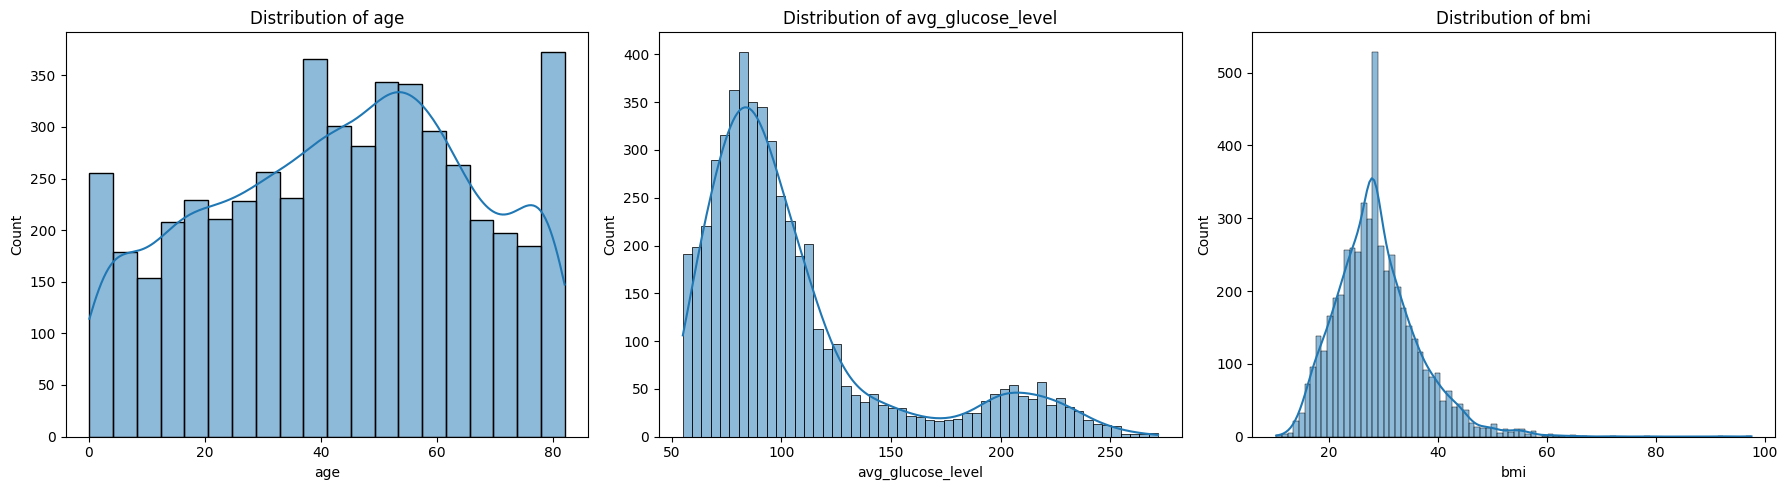

In [60]:
total = len(numerical_cols)
cols = 3
plt.figure(figsize=(18, 5 * ((total + cols - 1) // cols)))
for i, col in enumerate(numerical_cols):
    plt.subplot((total + cols - 1) // cols, cols, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

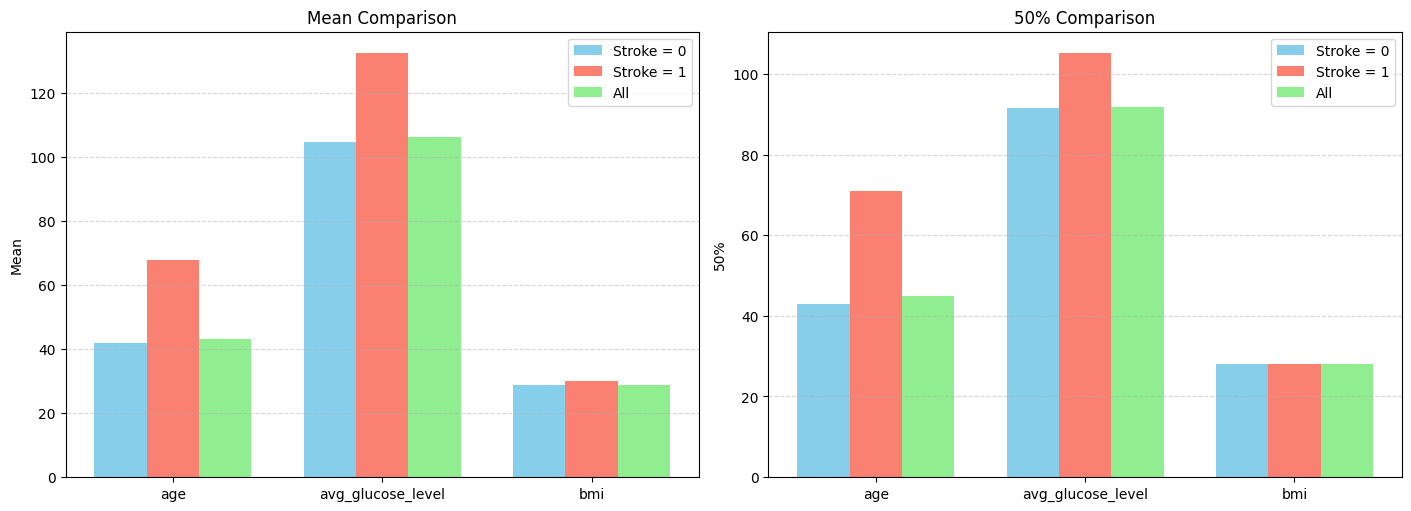

In [17]:
import matplotlib.pyplot as plt

final_df = final_df.set_index('stat')
stats_to_plot = ['mean', '50%']
features = ['age', 'avg_glucose_level', 'bmi']
width = 0.25
x = range(len(features))

fig, axs = plt.subplots(1, len(stats_to_plot), figsize=(14, 5), constrained_layout=True)

for i, stat in enumerate(stats_to_plot):
    cols_0 = [f'{feat}_0' for feat in features]
    cols_1 = [f'{feat}_1' for feat in features]
    cols_all = [f'{feat}_all' for feat in features]

    vals_0 = final_df.loc[stat, cols_0]
    vals_1 = final_df.loc[stat, cols_1]
    vals_all = final_df.loc[stat, cols_all]

    ax = axs[i]
    ax.bar([p - width for p in x], vals_0, width, label='Stroke = 0', color='skyblue')
    ax.bar(x, vals_1, width, label='Stroke = 1', color='salmon')
    ax.bar([p + width for p in x], vals_all, width, label='All', color='lightgreen')

    ax.set_xticks(x)
    ax.set_xticklabels(features)
    ax.set_ylabel(stat.capitalize())
    ax.set_title(f'{stat.capitalize()} Comparison')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


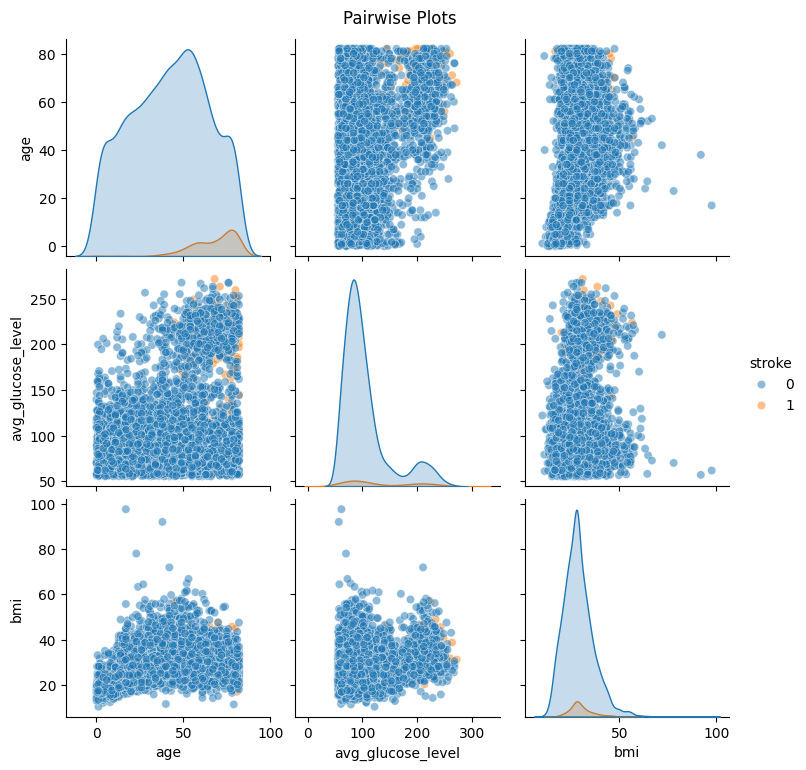

In [18]:
import seaborn as sns

# Only for numeric features
sns.pairplot(df, vars=['age', 'avg_glucose_level', 'bmi'], hue='stroke', plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Plots', y=1.02)
plt.show()


In [60]:
from scipy.stats import mannwhitneyu

features = ['age', 'avg_glucose_level', 'bmi']

for col in features:
    group_0 = df[df['stroke'] == 0][col].dropna()
    group_1 = df[df['stroke'] == 1][col].dropna()
    
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    print(f"{col} ➜ U-statistic: {stat:.2f}, p-value: {p:.5f}")
    if p < 0.05:
        print("→ Statistically significant difference\n")
    else:
        print("→ Not statistically significant\n")


age ➜ U-statistic: 200263.50, p-value: 0.00000
→ Statistically significant difference

avg_glucose_level ➜ U-statistic: 471239.00, p-value: 0.00000
→ Statistically significant difference

bmi ➜ U-statistic: 413278.50, p-value: 0.00010
→ Statistically significant difference



### 1.3.3 Categorical Distribution Plot

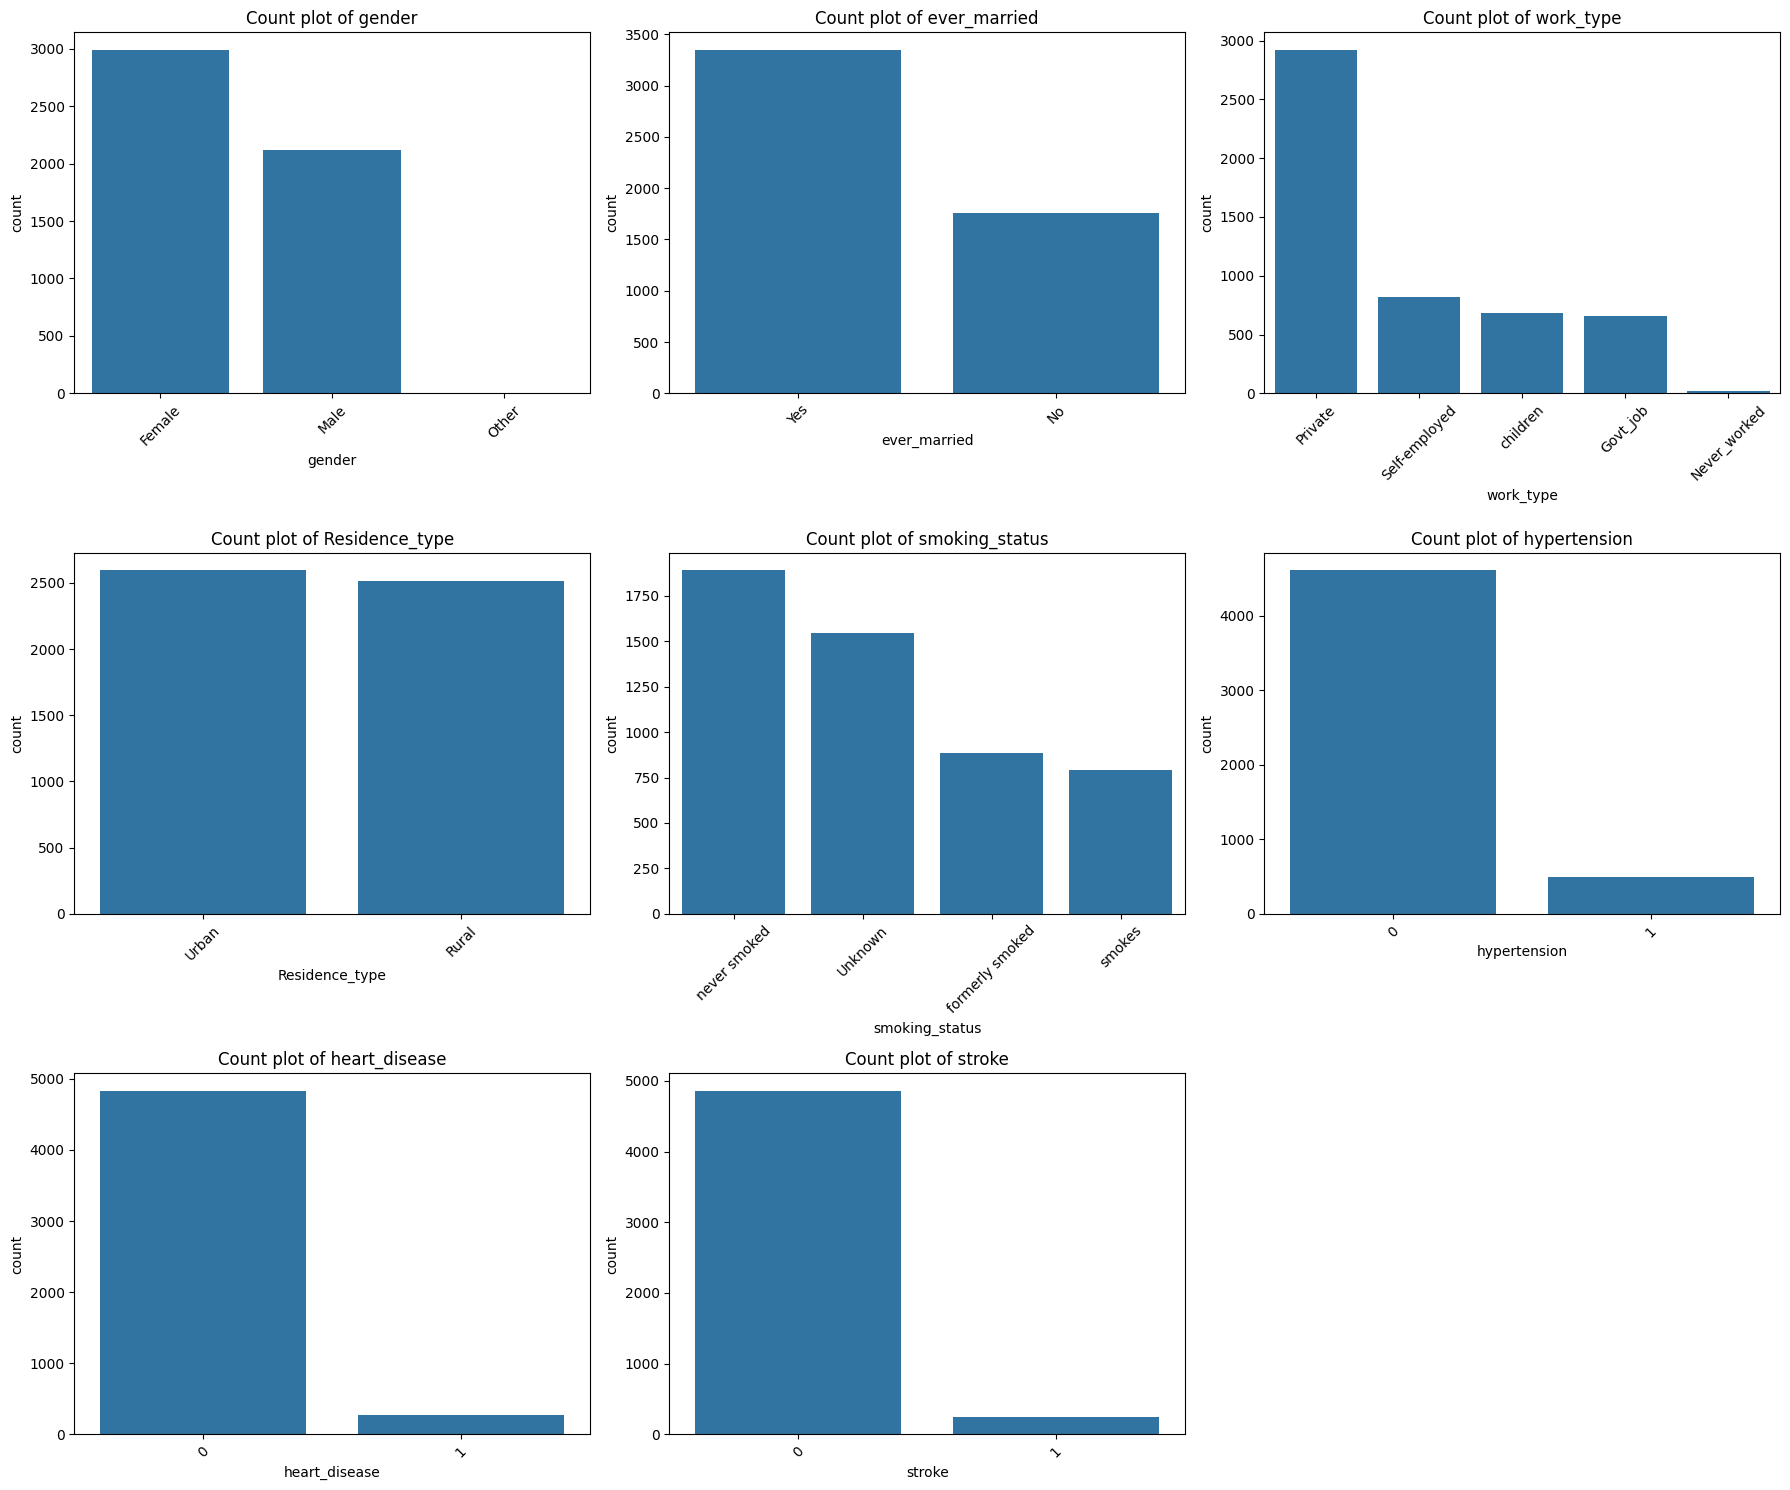

In [64]:


# cols = 3  # Number of columns per row
total = len(categorical_cols)

plt.figure(figsize=(18, 5 * ((total + 3 - 1) // cols)))

for i, col in enumerate(categorical_cols):
    plt.subplot((total + cols - 1) // cols, cols, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


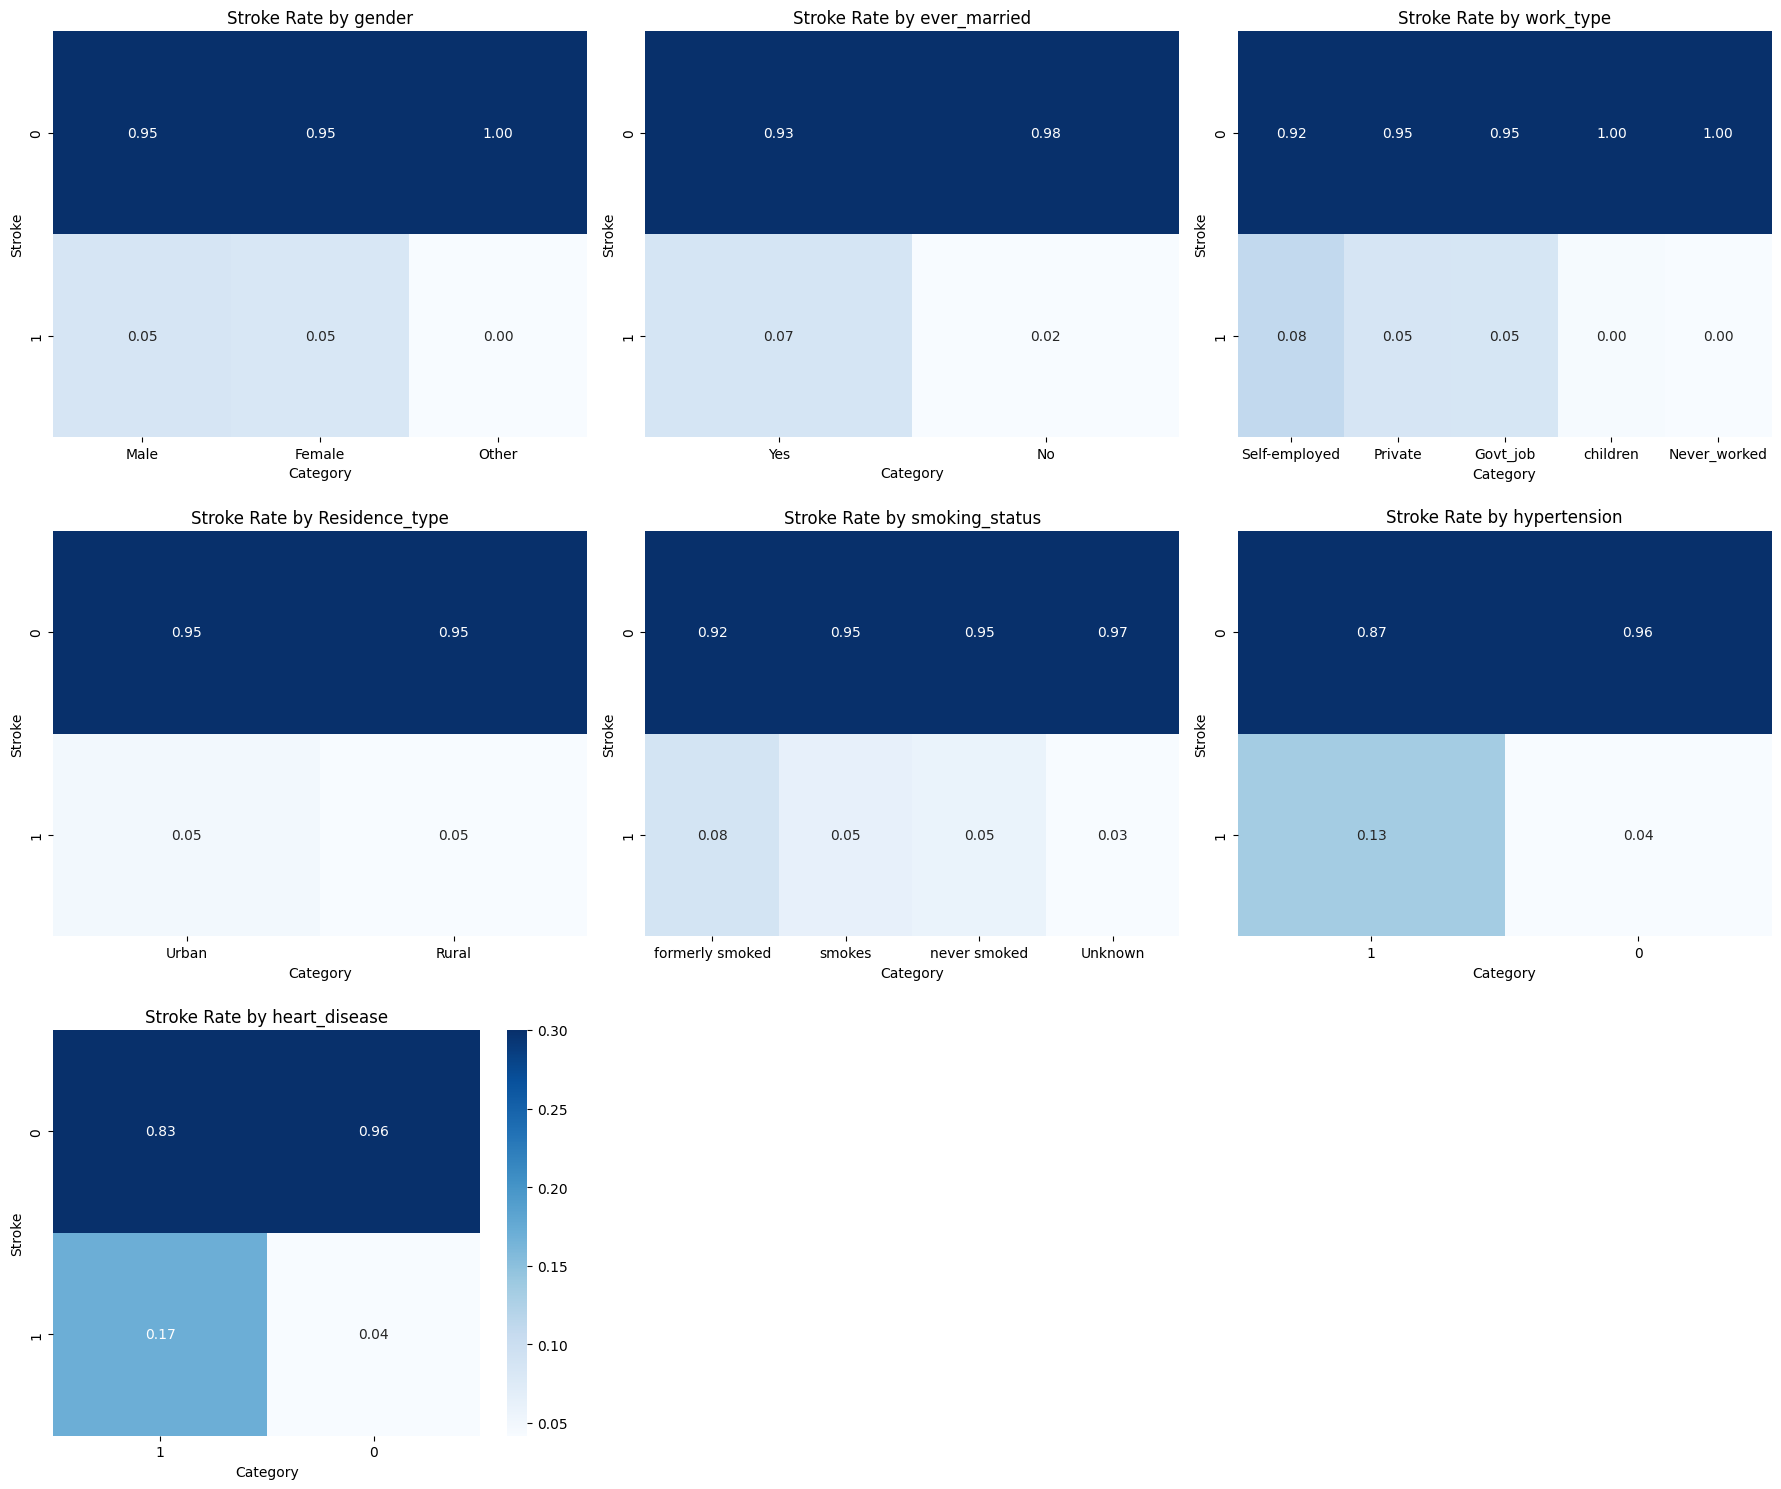

In [19]:

# Exclude target
filtered_cats = categorical_cols.copy()
filtered_cats.remove('stroke')

cols = 3
total = len(filtered_cats)
rows = (total + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(filtered_cats):
    # Calculate stroke rate per category
    ct = pd.crosstab(df[col], df['stroke'], normalize='index')  # stroke=0 and stroke=1 as columns

    # Sort by stroke rate (stroke=1)
    if 1 in ct.columns:
        ct = ct.sort_values(by=1, ascending=False)

    # Transpose to put stroke on y-axis (optional)
    ct_plot = ct.T  # shape: [stroke=0, stroke=1] x categories

    # Plot heatmap
    sns.heatmap(ct_plot, annot=True, cmap='Blues', vmax=0.3, fmt='.2f', ax=axes[i], 
                cbar=i == total - 1)

    axes[i].set_title(f'Stroke Rate by {col}')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Stroke')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=2)
plt.show()


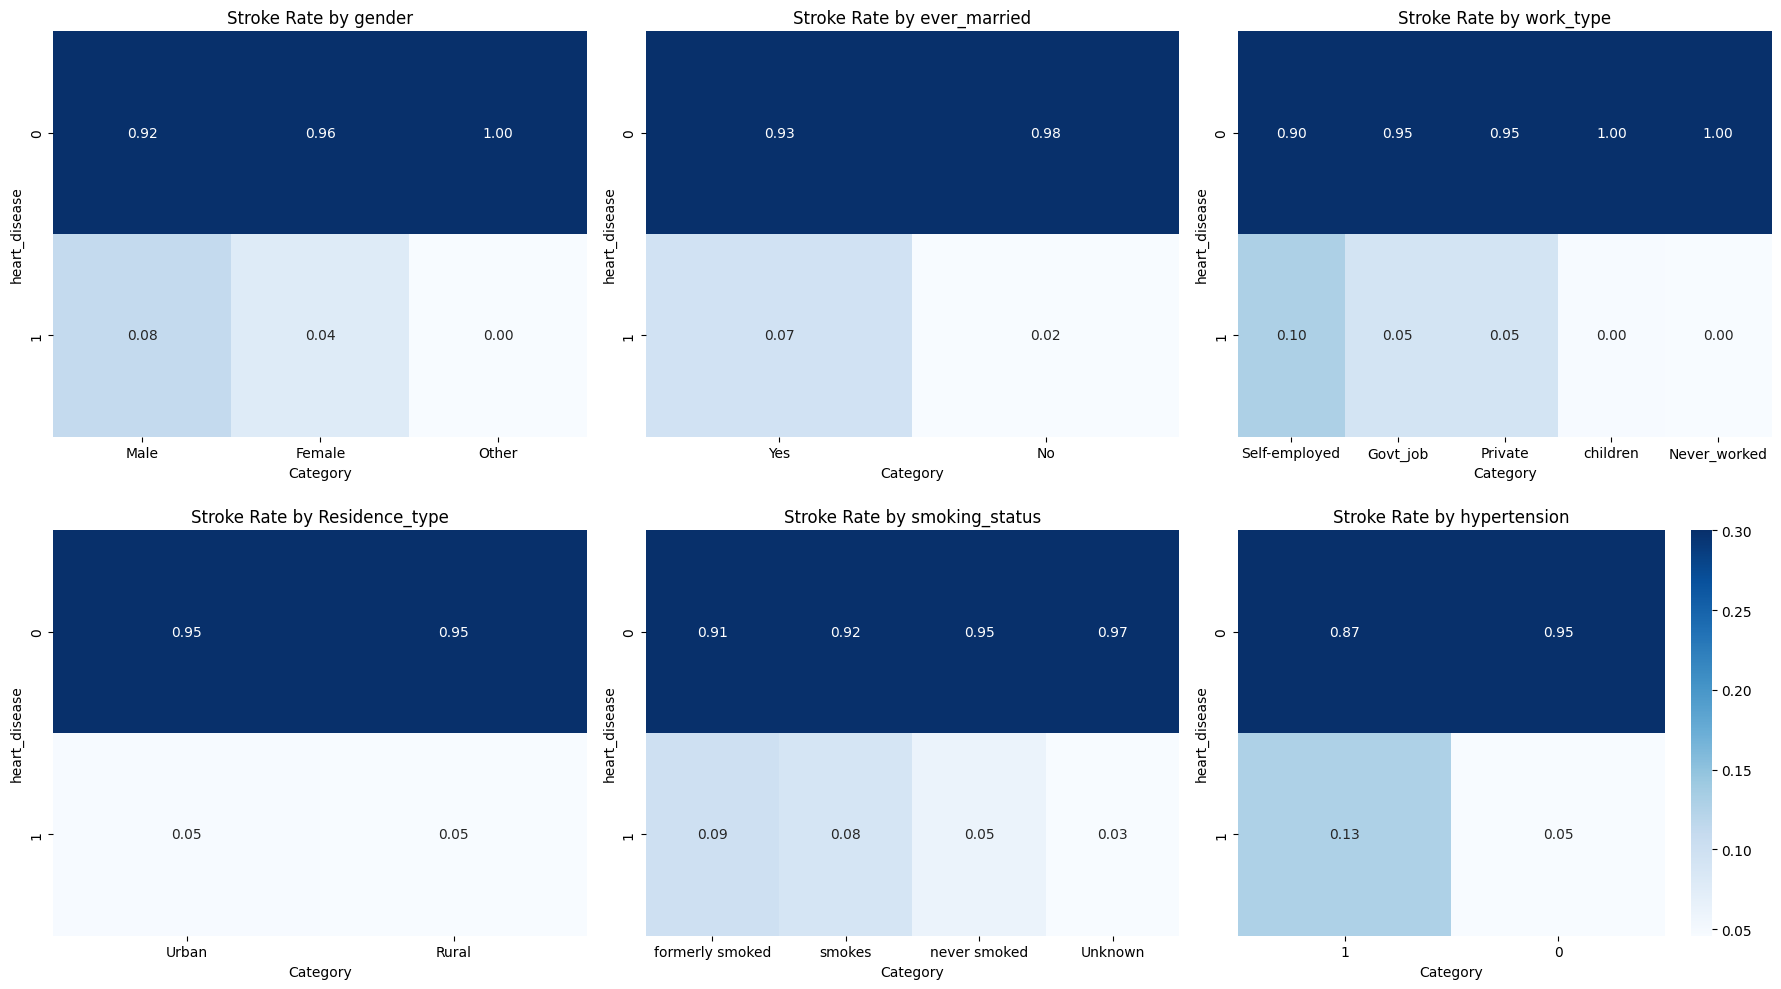

In [32]:

# Exclude target
filtered_cats = categorical_cols.copy()
filtered_cats.remove('heart_disease')
filtered_cats.remove('stroke')

cols = 3
total = len(filtered_cats)
rows = (total + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(filtered_cats):
    # Calculate stroke rate per category
    ct = pd.crosstab(df[col], df['heart_disease'], normalize='index')  # stroke=0 and stroke=1 as columns

    # Sort by stroke rate (stroke=1)
    if 1 in ct.columns:
        ct = ct.sort_values(by=1, ascending=False)

    # Transpose to put stroke on y-axis (optional)
    ct_plot = ct.T  # shape: [stroke=0, stroke=1] x categories

    # Plot heatmap
    sns.heatmap(ct_plot, annot=True, cmap='Blues', vmax=0.3, fmt='.2f', ax=axes[i], 
                cbar=i == total - 1)

    axes[i].set_title(f'Stroke Rate by {col}')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('heart_disease')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=2)
plt.show()


In [33]:
df[categorical_cols].to_csv("stroke_categorical_columns.csv", index=False)

In [ ]:
from plot_utils import plot_categorical_heatmaps

filtered_cats = categorical_cols.copy()
filtered_cats.remove('stroke')

plot_categorical_heatmaps(df, filtered_cats, target_col='stroke', vmax=0.3)


In [29]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Example usage:
cat_vars = ['work_type', 'gender', 'smoking_status', 'hypertension', 'heart_disease']

# Calculate pairwise Cramér's V and display as a matrix
cramers_results = pd.DataFrame(index=cat_vars, columns=cat_vars)

for var1 in cat_vars:
    for var2 in cat_vars:
        cramers_results.loc[var1, var2] = cramers_v(df[var1], df[var2])

print(cramers_results.astype(float))


                work_type    gender  smoking_status  hypertension  \
work_type        1.000000  0.064921        0.301021      0.162659   
gender           0.064921  1.000000        0.074903      0.021715   
smoking_status   0.301021  0.074903        1.000000      0.142575   
hypertension     0.162659  0.021715        0.142575      0.998888   
heart_disease    0.117627  0.085749        0.093483      0.106847   

                heart_disease  
work_type            0.117627  
gender               0.085749  
smoking_status       0.093483  
hypertension         0.106847  
heart_disease        0.998085  


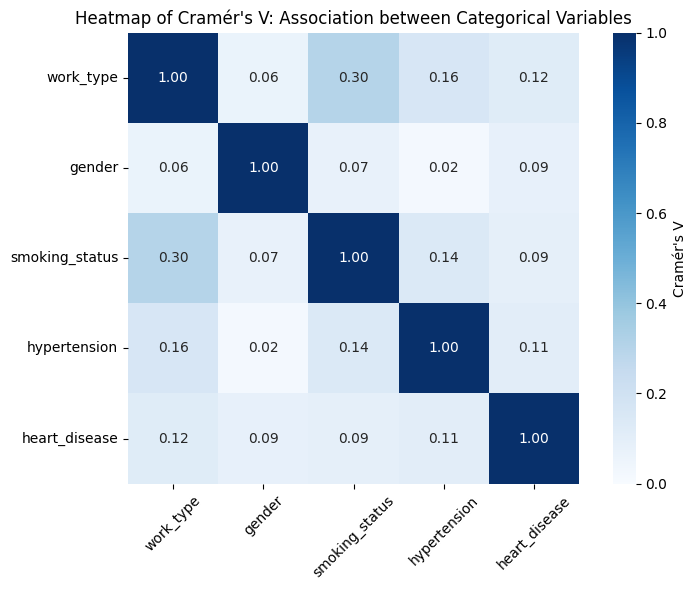

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming your cramers_results DataFrame (string values), convert to float:
cramers_matrix = cramers_results.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, fmt='.2f', square=True,
            cbar_kws={'label': "Cramér's V"})
plt.title("Heatmap of Cramér's V: Association between Categorical Variables")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare dataframe with encoded categorical columns only
predictors = df.drop(columns=["stroke"])

# Encode categorical columns
label_encoders = {}
for col in predictors.select_dtypes(include="object").columns:
    le = LabelEncoder()
    predictors[col] = le.fit_transform(predictors[col])
    label_encoders[col] = le

cols = predictors.columns
mi_matrix = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        # Mutual info is symmetric, so compute only once
        if pd.isnull(mi_matrix.loc[col1, col2]):
            mi = mutual_info_score(predictors[col1], predictors[col2])
            mi_matrix.loc[col1, col2] = mi
            mi_matrix.loc[col2, col1] = mi

# Convert matrix values to float
mi_matrix = mi_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mutual Information Among Predictors")
plt.show()


C:\Users\Ola\datascience\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\Ola\datascience\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


ValueError: Input contains NaN.

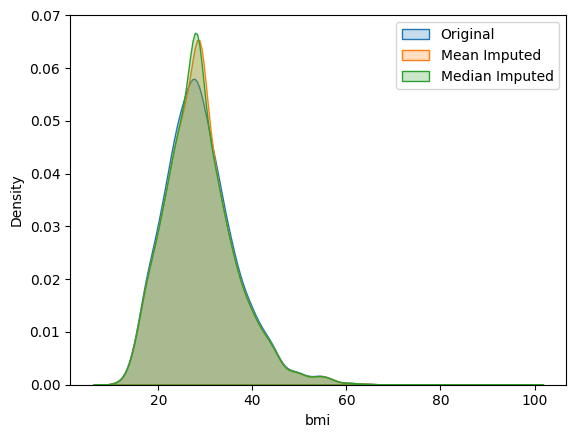

In [14]:
bmi_mean = df['bmi'].fillna(df['bmi'].mean())
bmi_median = df['bmi'].fillna(df['bmi'].median())

sns.kdeplot(df['bmi'], label='Original', fill=True)
sns.kdeplot(bmi_mean, label='Mean Imputed', fill=True)
sns.kdeplot(bmi_median, label='Median Imputed', fill=True)
plt.legend()


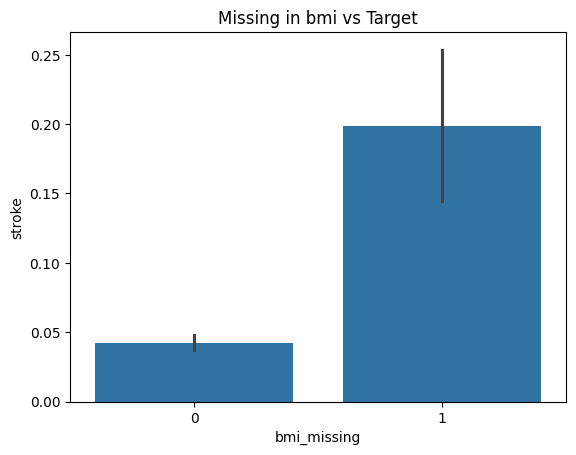

In [24]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[f'{col}_missing'] = df[col].isnull().astype(int)
        sns.barplot(x=f'{col}_missing', y='stroke', data=df)
        plt.title(f'Missing in {col} vs Target')
        plt.show()


# Statistical Inferences

## Hypothesis 1:

## Hypothesis 2:

In [34]:
import pandas as pd
import numpy as np

df_inference = df.copy()
# Create age group: Younger (<40), Older (>=40)
df_inference['age_group'] = np.where(df_inference['age'] < 40, 'younger', 'older')

# Combine with marital status
df_inference['age_marital_group'] = df_inference['age_group'] + '_' + df_inference['ever_married'].str.lower()


In [35]:
# Stroke rate per group
stroke_rate = df_inference.groupby('age_marital_group')['stroke'].mean().sort_values(ascending=False)
print(stroke_rate)


age_marital_group
older_no       0.100775
older_yes      0.080164
younger_yes    0.007452
younger_no     0.002001
Name: stroke, dtype: float64


In [36]:
from scipy.stats import chi2_contingency

# Create crosstab
contingency = pd.crosstab(df_inference['age_marital_group'], df_inference['stroke'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("p-value:", p)


Chi-square statistic: 167.52585190031078
p-value: 4.352853305973627e-36


In [37]:
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations
import numpy as np

# Get stroke counts for each group
group_counts = df_inference.groupby('age_marital_group')['stroke'].value_counts().unstack().fillna(0)

# Prepare data for pairwise tests
groups = group_counts.index.tolist()
results = []

for g1, g2 in combinations(groups, 2):
    count = np.array([group_counts.loc[g1, 1], group_counts.loc[g2, 1]])  # stroke = 1
    nobs = np.array([group_counts.loc[g1].sum(), group_counts.loc[g2].sum()])

    stat, pval = proportions_ztest(count, nobs)
    results.append((f"{g1} vs {g2}", stat, pval))

# Apply Bonferroni correction
bonferroni_alpha = 0.05 / len(results)

for r in results:
    print(f"{r[0]} | z = {r[1]:.3f} | p = {r[2]:.5f} | {'Significant' if r[2] < bonferroni_alpha else 'Not Significant'}")


older_no vs older_yes | z = 1.153 | p = 0.24905 | Not Significant
older_no vs younger_no | z = 11.502 | p = 0.00000 | Significant
older_no vs younger_yes | z = 7.093 | p = 0.00000 | Significant
older_yes vs younger_no | z = 10.903 | p = 0.00000 | Significant
older_yes vs younger_yes | z = 6.803 | p = 0.00000 | Significant
younger_no vs younger_yes | z = -1.936 | p = 0.05285 | Not Significant


#### Interpretations

* The older age groups (married or unmarried) have significantly higher stroke rates compared to younger groups.

* Within younger people, marital status doesn’t show a statistically significant difference.

* Within older people, marital status also doesn't lead to a significant difference.

So the age factor seems dominant, while marital status has little effect within age groups, but combined differences are significant.

### confidence inyerval of age

Now we infer that age might be factor to be affected by stroke 

LEarn: https://researchfeatures.com/how-analyse-categorical-data/

In [41]:
import numpy as np
import scipy.stats as stats

def mean_ci(series, confidence=0.95):
    data = series.dropna()
    mean = np.mean(data)
    sem = stats.sem(data)
    margin = sem * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return mean, mean - margin, mean + margin

# CI for stroke = 1
mean1, lower1, upper1 = mean_ci(df[df['stroke'] == 1]['age'])
print(f"Stroke=1 -> Mean age: {mean1:.2f}, 95% CI: [{lower1:.2f}, {upper1:.2f}]")

# CI for stroke = 0
mean0, lower0, upper0 = mean_ci(df[df['stroke'] == 0]['age'])
print(f"Stroke=0 -> Mean age: {mean0:.2f}, 95% CI: [{lower0:.2f}, {upper0:.2f}]")


Stroke=1 -> Mean age: 67.73, 95% CI: [66.14, 69.32]
Stroke=0 -> Mean age: 41.97, 95% CI: [41.34, 42.60]


* The confidence intervals do not overlap, which strongly supports the conclusion that:

* People who had a stroke are significantly older, on average, than those who didn’t.

This supports both the statistical test you performed and the clinical intuition.

## Missing data analysis